* [parity pairs](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rnn_class/util.py)
* [MLP](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rnn_class/mlp_parity.py)
* [RNN](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rnn_class/srn_parity.py)

**Parity problem**

Data transmission in communication systems.
Suppose a bit gets reversed - how can we detect this?
Add a parity bit t the end of each message.

Require that each message has an even number of 1s.
If the message has odd number of 1s, add a parity bit to make total even.
If message has an even number os 1s, add a parity bit to 0.

* If 0 and see 1, switch to 1.
* If 1 and see 1, switch to 0.
* If see 0, keep the same state.



In [158]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import theano
import theano.tensor as T

In [159]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi+Mo)    

def all_parity_pairs(nbit):
    # total number of samples (Ntotal) will be a multiple of 100
    N = 2**nbit
    remainder = 100 - (N % 100)
    Ntotal = N + remainder
    X = np.zeros((Ntotal, nbit))
    Y = np.zeros(Ntotal)
    for i in range(Ntotal):
        ii = i % N
        # now generate the ith sample
        for j in range(nbit):
            if ii % (2**(j+1)) != 0:
                ii -= 2**j
                X[i,j] = 1
        Y[i] = X[i].sum() % 2
    return X, Y

def all_parity_pairs_with_sequence_labels(nbit):
    X, Y = all_parity_pairs(nbit)
    N, t = X.shape
    # we want every time step to have a label
    Y_t = np.zeros(X.shape, dtype=np.int32)
    for n in range(N):
        ones_count = 0
        for i in range(t):
            if X[n,i] == 1:
                ones_count += 1
            if ones_count % 2 == 1:
                Y_t[n,i] = 1

    X = X.reshape(N, t, 1).astype(np.float32)
    return X, Y_t

# MLP

In [160]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W = init_weight(M1, M2)
        b = np.zeros(M2)
        self.W = theano.shared(W, 'W_{}'.format(self.id))
        self.b = theano.shared(b, 'b_{}'.format(self.id))
        self.params = [self.W, self.b]

    def forward(self, X):
        return T.nnet.relu(X.dot(self.W)+self.b)

In [161]:
class ANN:
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=10e-3, mu=0.99, reg=1.0e-11, 
            epochs=400, batch_size=20, print_period=1, show_fig=False):

        X = X.astype(np.float32)
        Y = Y.astype(np.int32)
        
        # Initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W = init_weight(M1, K)
        b = np.zeros(K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')
        
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params
            
        # Momentum
        dparams = [ theano.shared(np.zeros(p.get_value().shape)) for p in self.params ]
        
        # RMSProp
        cache = [ theano.shared(np.zeros(p.get_value().shape)) for p in self.params ]
        
        # Theano funcions and variables
        thX = T.matrix('X')
        thY = T.ivector('Y')
        pY = self.forward(thX)
        
        rcost = reg * T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean( T.log(pY[T.arange(thY.shape[0]), thY]) ) + rcost
        prediction = self.predict(thX)
        grads = T.grad(cost, self.params)
        
        # momentum only
        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]
        
        train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            updates=updates,
        )
        
        n_batches = N//batch_size
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_size:(j+1)*batch_size]
                Ybatch = Y[j*batch_size:(j+1)*batch_size]
                
                c, p = train_op(Xbatch, Ybatch)
            if i%print_period==0:
                c = float(np.array_str(c))
                costs.append(c)
                e = np.mean(Ybatch!=p)
                
                print('cost: {:.3f}, error: {:.3f}'.format(c,e))
        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax( Z.dot(self.W)+self.b )
    
    def predict(self, X):
        pY = self.forward(X)
        return T.argmax(pY, axis=1)

cost: 0.695, error: 0.400
cost: 0.688, error: 0.200
cost: 0.647, error: 0.150
cost: 0.505, error: 0.050
cost: 0.299, error: 0.000
cost: 0.131, error: 0.000


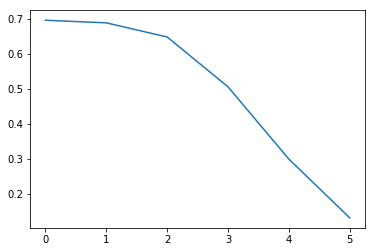

In [162]:
X, Y = all_parity_pairs(12)
model = ANN([2048])
model.fit(X, Y, learning_rate=10e-5, print_period=50, epochs=300, show_fig=True)

cost: 0.710, error: 0.700
cost: 0.675, error: 0.400
cost: 0.027, error: 0.000
cost: 0.001, error: 0.000
cost: 0.000, error: 0.000


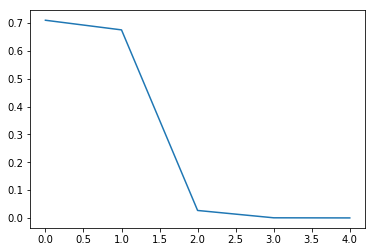

In [163]:
X, Y = all_parity_pairs(12)
model = ANN([1024]*2)
model.fit(X, Y, learning_rate=10e-4, print_period=20, epochs=100, show_fig=True)

# RNN - simple Recurrent Unit

In [165]:
class SimpleRNN:
    def __init__(self, M):
        self.M = M
        
    def fit(self, X, Y, learning_rate=10e-1, mu=0.99, reg=1.0, print_period=20,
            activation=T.tanh, epochs=100, show_fig=False):
        D = X[0].shape[1] # X is of size N x T(n) x D
        K = len(set(Y.flatten())) # sequence of targets
        N = len(Y)
        M = self.M
        self.f = activation
        
        # Intial weights
        Wx = init_weight(D, M)
        Wh = init_weight(M, M)
        bh = np.zeros(M)
        h0 = np.zeros(M)
        Wo = init_weight(M, K)
        bo = np.zeros(K)
        
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.Wx, self.Wh, self.bh, self.h0, self.Wo, self.bo]
        
        thX = T.fmatrix('X')
        thY = T.ivector('Y')
        
        def recurrence(x_t, h_t1): # x(t), h(t-1)
            # returns h(t), y(t)
            h_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t, y_t
        
        [h, y], _ = theano.scan(
            fn=recurrence,
            sequences=thX,
            outputs_info=[self.h0, None],
            n_steps=thX.shape[0],
        )

        py_x = y[:, 0, :]
        prediction = T.argmax(py_x, axis=1)
        
        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        
        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [ # momentum updates
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]
        
        self.predict_op = theano.function(
            inputs=[thX],
            outputs=prediction
        )
        self.train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction, y],
            updates=updates
        )
        
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            n_correct = 0
            cost = 0
            for j in range(N):
                c, p, rout = self.train_op(X[j], Y[j])
                cost += c
                if p[-1]==Y[j,-1]:
                    n_correct += 1
            if i%print_period==0:
                print('Cost: {:.3f}, error: {:.3f}'.format(cost, float(n_correct)/N))
            costs.append(cost)
            if n_correct==N:
                break
        if show_fig:
            plt.plot(costs)
            plt.show()

Cost: 2851.615, error: 0.504
Cost: 2826.450, error: 0.500
Cost: 2680.538, error: 0.501
Cost: 2620.988, error: 0.493
Cost: 2613.769, error: 0.487
Cost: 2609.107, error: 0.488
Cost: 2569.162, error: 0.507


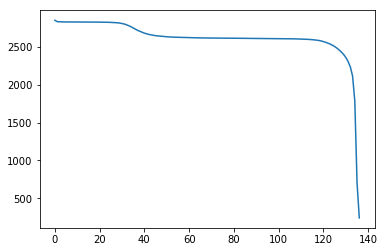

In [166]:
X, Y = all_parity_pairs_with_sequence_labels(12)
rnn = SimpleRNN(4) # 4 hidden units
rnn.fit(X, Y, learning_rate=10e-5, epochs=200, activation=T.nnet.sigmoid, show_fig=True)